In [1]:
 # Setup & Data Loading
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Load the featured data from Notebook 1
DATA_PATH = '../data/processed/df_featured.csv'
try:
    df = pd.read_csv(DATA_PATH, parse_dates=['Date'])
    print("Featured data loaded successfully.")
except FileNotFoundError:
    print("ERROR: Please run Notebook 01 first to generate df_featured.csv")




/var/folders/2d/9g_4f9mj0z381s0m_q13fm8h0000gn/T/ipykernel_24148/1442940227.py:15: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH, parse_dates=['Date'])


Featured data loaded successfully.


In [2]:
# Advanced Feature Engineering (Model-Specific)
print("\nCreating advanced time-series features...")

# Sort values to ensure correct lag/roll calculation
df.sort_values(['Store', 'Date'], inplace=True)

# Lag features (sales from previous days)
for i in range(7, 15):  # Lags from 1 week to 2 weeks ago
    df[f'Sales_Lag_{i}'] = df.groupby('Store')['Sales'].shift(i)

# Rolling window features (e.g., 2-week moving average of sales from 1 week ago)
df['Sales_Rolling_Mean_14'] = df.groupby('Store')['Sales'].transform(lambda x: x.shift(7).rolling(14).mean())
df['Sales_Rolling_Std_14'] = df.groupby('Store')['Sales'].transform(lambda x: x.shift(7).rolling(14).std())

# Drop rows with NaNs created by lags/rolling features
df.dropna(inplace=True)
print("Advanced features created. Data shape:", df.shape)




Creating advanced time-series features...
Advanced features created. Data shape: (409626, 33)


In [3]:

# Pre-Modeling Setup 
# Dummifying categorical variables for the model
df = pd.get_dummies(df, columns=['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval'], drop_first=True)

print("\nSanitizing column names for LightGBM compatibility...")
import re
# Replacing ny characters that are not letters, numbers, or underscores with an underscore
df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
print("Column names sanitized.")

# Time-based train-test split
split_date = df['Date'].max() - pd.Timedelta(days=42)
train = df[df['Date'] <= split_date]
test = df[df['Date'] > split_date]

# Defining features (X) and target (y)
features = [col for col in df.columns if col not in ['Date', 'Sales', 'Customers', 'Open']]
X_train, y_train = train[features], train['Sales']
X_test, y_test = test[features], test['Sales']

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")




Sanitizing column names for LightGBM compatibility...
Column names sanitized.
Train shape: (389044, 36), Test shape: (20582, 36)


In [4]:
# Modeling
print("\nTraining LightGBM model...")

lgb_params = {
    'objective': 'regression_l1', # MAE
    'metric': 'mae',
    'n_estimators': 3000,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}

model_lgb = lgb.LGBMRegressor(**lgb_params)
model_lgb.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric='mae',
              callbacks=[lgb.early_stopping(100, verbose=True)])

# Predict on the test set
y_pred = model_lgb.predict(X_test)


Training LightGBM model...
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2950]	valid_0's l1: 632.077



Evaluating model performance...
Test MAE (Mean Absolute Error): 632.08
Test RMSE (Root Mean Squared Error): 952.77

Generating plot for the first available store in the test set: Store 2


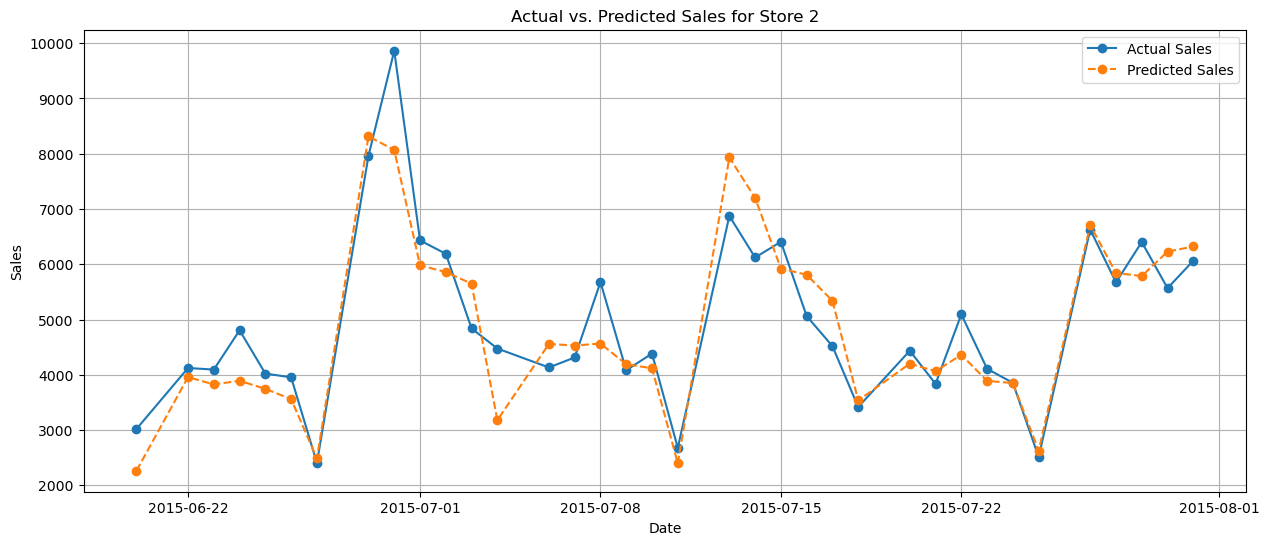


Model and column list saved to ../models/

--- Notebook 3 Complete ---


In [5]:
# Evaluation 
print("\nEvaluating model performance...")
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test MAE (Mean Absolute Error): {mae:.2f}")
print(f"Test RMSE (Root Mean Squared Error): {rmse:.2f}")

available_stores_in_test = test['Store'].unique()

if len(available_stores_in_test) > 0:
    # Pick the first available store for plotting
    store_to_plot = available_stores_in_test[0]
    print(f"\nGenerating plot for the first available store in the test set: Store {store_to_plot}")

    # Create a DataFrame for the sample store
    sample_store_df = test[test['Store'] == store_to_plot].copy()
    
    # Get the predictions for this specific store
    # Note: We use the index from the sample_store_df to correctly align predictions
    predictions_for_store = model_lgb.predict(X_test.loc[sample_store_df.index])
    sample_store_df['Predicted'] = predictions_for_store

    # Create the plot
    plt.figure(figsize=(15, 6))
    plt.plot(sample_store_df['Date'], sample_store_df['Sales'], 'o-', label='Actual Sales')
    plt.plot(sample_store_df['Date'], sample_store_df['Predicted'], 'o--', label='Predicted Sales')
    
    plt.title(f'Actual vs. Predicted Sales for Store {store_to_plot}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Could not find any stores in the test set to generate a plot.")

# Saving the Final Model 
MODEL_DIR = '../models/'
os.makedirs(MODEL_DIR, exist_ok=True)

# Saving the trained model
joblib.dump(model_lgb, os.path.join(MODEL_DIR, 'lgbm_forecaster.pkl'))
# Saving the list of columns used for training
joblib.dump(features, os.path.join(MODEL_DIR, 'model_columns.pkl'))

print(f"\nModel and column list saved to {MODEL_DIR}")
print("\n--- Notebook 3 Complete ---")